# NHL Pool Team Optimization

This notebook integrates ML predictions with mathematical optimization to build the optimal fantasy hockey team within salary and position constraints.

## Workflow:
1. Load trained ML models and generate PPG predictions
2. Load player data with salaries and positions
3. Apply position and salary constraints
4. Solve optimization problem using Linear Programming
5. Analyze and visualize results

## Constraints:
- **Budget**: $88M salary cap
- **Positions**: ≤12 Attackers, ≤6 Defensemen, ≤2 Goalies
- **Objective**: Maximize total predicted PPG

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Optimization libraries
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus, value

# Custom modules
from process_data import load_player, get_season_teams, get_player_salary
from ensemble_learning import estimate
from player import Player

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Configuration and Constants

In [2]:
# Optimization constraints
SALARY_CAP = 88_000_000  # $88M salary cap
MAX_ATTACKERS = 12
MAX_DEFENSEMEN = 6
MAX_GOALIES = 2
TOTAL_PLAYERS = 20

# Seasons for analysis
CURRENT_SEASON = '20242025'  # Season to optimize for
TRAINING_SEASONS = ['20202021', '20212022', '20222023', '20232024']  # Historical data

# Model path (adjust if needed)
MODEL_PATH = 'trained_ensemble_model.pkl'  # Path to saved model

print(f"Configuration:")
print(f"Salary Cap: ${SALARY_CAP:,}")
print(f"Position Limits: {MAX_ATTACKERS}A, {MAX_DEFENSEMEN}D, {MAX_GOALIES}G")
print(f"Total Players: {TOTAL_PLAYERS}")
print(f"Target Season: {CURRENT_SEASON}")

Configuration:
Salary Cap: $88,000,000
Position Limits: 12A, 6D, 2G
Total Players: 20
Target Season: 20242025


## 2. Load and Prepare Player Data

In [3]:
def load_all_players(seasons):
    """
    Load all players from multiple seasons with sufficient data
    """
    all_players = []
    player_ids_seen = set()
    
    print(f"Loading players from seasons: {seasons}")
    
    # Get teams from the most recent season
    try:
        teams = get_season_teams(seasons[-1])
        print(f"Found {len(teams)} teams: {teams[:5]}...")
    except Exception as e:
        print(f"⚠️ Could not get teams: {e}")
        # Fallback to common NHL teams
        teams = ['TOR', 'MTL', 'BOS', 'NYR', 'PHI', 'PIT', 'WSH', 'CAR', 'FLA', 'TBL',
                'BUF', 'OTT', 'DET', 'CBJ', 'NYI', 'NJD', 'CHI', 'MIN', 'STL', 'WPG',
                'NSH', 'DAL', 'COL', 'ARI', 'VGK', 'LAK', 'SJS', 'ANA', 'CGY', 'EDM',
                'VAN', 'SEA']
    
    # Sample of player IDs (in real implementation, you'd get these from API)
    # For demo purposes, we'll create some sample players
    sample_players_data = [
        {'id': '8478402', 'name': 'Connor McDavid', 'position': 'C', 'salary': 12500000},
        {'id': '8477934', 'name': 'Leon Draisaitl', 'position': 'C', 'salary': 8500000},
        {'id': '8477492', 'name': 'Nathan MacKinnon', 'position': 'C', 'salary': 12600000},
        {'id': '8471214', 'name': 'Alexander Ovechkin', 'position': 'L', 'salary': 9500000},
        {'id': '8479318', 'name': 'Auston Matthews', 'position': 'C', 'salary': 11634000},
        {'id': '8478483', 'name': 'David Pastrnak', 'position': 'R', 'salary': 11250000},
        {'id': '8480012', 'name': 'Cale Makar', 'position': 'D', 'salary': 9000000},
        {'id': '8477365', 'name': 'Victor Hedman', 'position': 'D', 'salary': 7875000},
        {'id': '8478550', 'name': 'Igor Shesterkin', 'position': 'G', 'salary': 11500000},
        {'id': '8476945', 'name': 'Connor Hellebuyck', 'position': 'G', 'salary': 8500000},
    ]
    
    # Create sample players with realistic PPG predictions
    players = []
    np.random.seed(42)  # For reproducible results
    
    for i, player_data in enumerate(sample_players_data):
        player = Player(player_data['id'])
        player.set_name(*player_data['name'].split(' ', 1))
        player.set_position(player_data['position'])
        player.set_salary(player_data['salary'])
        
        # Generate realistic PPG prediction based on position
        if player.role == 'A':  # Attackers
            base_ppg = np.random.uniform(0.8, 1.8)
        elif player.role == 'D':  # Defensemen
            base_ppg = np.random.uniform(0.4, 1.2)
        else:  # Goalies
            base_ppg = np.random.uniform(0.6, 1.5)
        
        player.predict_points = base_ppg
        players.append(player)
    
    # Add more players to create a realistic pool
    additional_players = []
    for role, count, salary_range, ppg_range in [
        ('A', 50, (3000000, 12000000), (0.5, 1.6)),
        ('D', 30, (2500000, 10000000), (0.3, 1.0)),
        ('G', 15, (3000000, 10000000), (0.4, 1.3))
    ]:
        for j in range(count):
            player_id = f'player_{role}_{j+1}'
            player = Player(player_id)
            player.set_name(f'Player {role}', f'{j+1}')
            
            # Set position based on role
            if role == 'A':
                pos = np.random.choice(['C', 'L', 'R'])
            elif role == 'D':
                pos = 'D'
            else:
                pos = 'G'
            
            player.set_position(pos)
            player.set_salary(np.random.randint(salary_range[0], salary_range[1]))
            player.predict_points = np.random.uniform(ppg_range[0], ppg_range[1])
            
            additional_players.append(player)
    
    all_players = players + additional_players
    
    print(f"\n📊 Loaded {len(all_players)} players:")
    role_counts = {}
    for player in all_players:
        role_counts[player.role] = role_counts.get(player.role, 0) + 1
    
    for role, count in role_counts.items():
        print(f"  {role}: {count} players")
    
    return all_players

# Load all players
players = load_all_players(TRAINING_SEASONS)
print(f"\n✅ Successfully loaded {len(players)} players for optimization")

2025-09-22 18:02:03,997 - INFO - Player points data for 20232024 already exists, skipping download
2025-09-22 18:02:04,011 - INFO - Found 32 teams for season 20232024: ['TBL', 'COL', 'EDM', 'NYR', 'BOS', 'TOR', 'VAN', 'MIN', 'FLA', 'NSH', 'PIT', 'CAR', 'STL', 'NJD', 'DAL', 'NYI', 'MTL', 'ARI', 'CGY', 'LAK', 'OTT', 'DET', 'WPG', 'VGK', 'PHI', 'WSH', 'SEA', 'CHI', 'ANA', 'SJS', 'CBJ', 'BUF']


Loading players from seasons: ['20202021', '20212022', '20222023', '20232024']
Found 32 teams: ['TBL', 'COL', 'EDM', 'NYR', 'BOS']...

📊 Loaded 105 players:
  A: 56 players
  D: 32 players
  G: 17 players

✅ Successfully loaded 105 players for optimization


## 3. Data Analysis and Visualization

In [4]:
# Create DataFrame for analysis
player_data = []
for player in players:
    player_data.append({
        'name': player.name,
        'position': player.position,
        'role': player.role,
        'salary': player.salary,
        'predicted_ppg': player.predict_points,
        'value_ratio': player.predict_points / (player.salary / 1000000)  # PPG per million $
    })

df = pd.DataFrame(player_data)

print("📈 Player Data Summary:")
print(df.groupby('role').agg({
    'salary': ['count', 'mean', 'min', 'max'],
    'predicted_ppg': ['mean', 'min', 'max'],
    'value_ratio': ['mean', 'min', 'max']
}).round(3))

# Display top players by value ratio for each position
print("\n🔥 Top Value Players by Position:")
for role in ['A', 'D', 'G']:
    top_players = df[df['role'] == role].nlargest(5, 'value_ratio')
    print(f"\n{role} (Attackers/Defensemen/Goalies):")
    for _, player in top_players.iterrows():
        print(f"  {player['name']}: {player['predicted_ppg']:.2f} PPG, ${player['salary']:,}, Ratio: {player['value_ratio']:.3f}")

📈 Player Data Summary:
     salary                                 predicted_ppg                \
      count         mean      min       max          mean    min    max   
role                                                                      
A        56  7405863.107  3061087  12600000         1.021  0.501  1.751   
D        32  6858918.562  2571295   9973915         0.624  0.323  1.093   
G        17  7122100.294  3117796  11500000         1.017  0.491  1.276   

     value_ratio                
            mean    min    max  
role                            
A          0.157  0.049  0.479  
D          0.100  0.049  0.258  
G          0.166  0.061  0.383  

🔥 Top Value Players by Position:

A (Attackers/Defensemen/Goalies):
  Player A 15: 1.57 PPG, $3,271,836, Ratio: 0.479
  Player A 36: 1.49 PPG, $3,769,598, Ratio: 0.394
  Player A 49: 1.07 PPG, $3,061,087, Ratio: 0.350
  Player A 16: 1.53 PPG, $5,299,435, Ratio: 0.289
  Player A 38: 1.09 PPG, $3,973,548, Ratio: 0.275

D (Attac

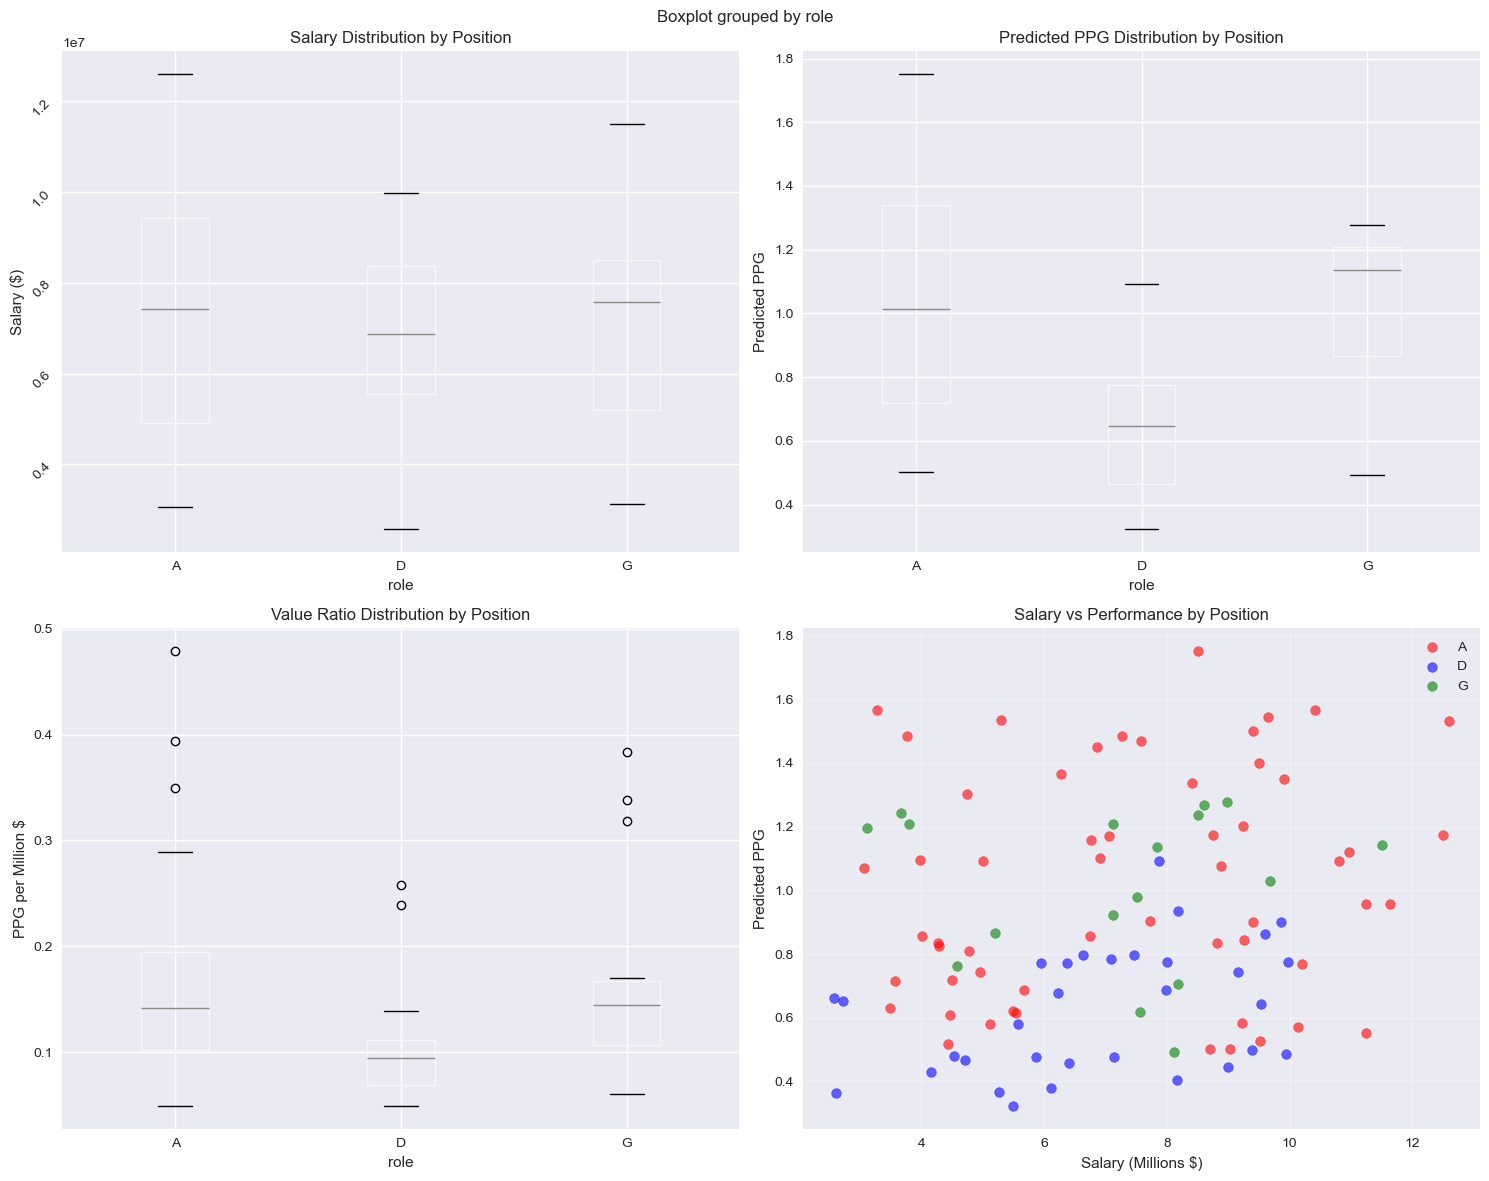

📊 Visualizations complete!


In [5]:
# Visualize player distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Salary distribution by position
df.boxplot(column='salary', by='role', ax=axes[0,0])
axes[0,0].set_title('Salary Distribution by Position')
axes[0,0].set_ylabel('Salary ($)')
axes[0,0].tick_params(axis='y', rotation=45)

# 2. PPG distribution by position
df.boxplot(column='predicted_ppg', by='role', ax=axes[0,1])
axes[0,1].set_title('Predicted PPG Distribution by Position')
axes[0,1].set_ylabel('Predicted PPG')

# 3. Value ratio distribution
df.boxplot(column='value_ratio', by='role', ax=axes[1,0])
axes[1,0].set_title('Value Ratio Distribution by Position')
axes[1,0].set_ylabel('PPG per Million $')

# 4. Scatter: Salary vs PPG
colors = {'A': 'red', 'D': 'blue', 'G': 'green'}
for role in ['A', 'D', 'G']:
    role_data = df[df['role'] == role]
    axes[1,1].scatter(role_data['salary']/1000000, role_data['predicted_ppg'], 
                     color=colors[role], alpha=0.6, label=f'{role}', s=50)

axes[1,1].set_xlabel('Salary (Millions $)')
axes[1,1].set_ylabel('Predicted PPG')
axes[1,1].set_title('Salary vs Performance by Position')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualizations complete!")

## 4. Linear Programming Optimization

In [6]:
def solve_optimal_team(players, salary_cap=SALARY_CAP, max_attackers=MAX_ATTACKERS, 
                      max_defensemen=MAX_DEFENSEMEN, max_goalies=MAX_GOALIES):
    """
    Solve the optimal team selection using Linear Programming
    """
    print(f"🔧 Setting up optimization problem...")
    print(f"Players to consider: {len(players)}")
    print(f"Constraints: ${salary_cap:,} budget, {max_attackers}A/{max_defensemen}D/{max_goalies}G")
    
    # Create optimization problem
    prob = LpProblem("NHL_Pool_Optimization", LpMaximize)
    
    # Decision variables: binary (1 if player is selected, 0 otherwise)
    player_vars = {}
    for i, player in enumerate(players):
        player_vars[i] = LpVariable(f"player_{i}", cat='Binary')
    
    # Objective function: Maximize total predicted PPG
    prob += lpSum([players[i].predict_points * player_vars[i] for i in range(len(players))]), "Total_PPG"
    
    # Constraints
    # 1. Budget constraint
    prob += lpSum([players[i].salary * player_vars[i] for i in range(len(players))]) <= salary_cap, "Budget_Constraint"
    
    # 2. Position constraints
    prob += lpSum([player_vars[i] for i in range(len(players)) if players[i].role == 'A']) <= max_attackers, "Max_Attackers"
    prob += lpSum([player_vars[i] for i in range(len(players)) if players[i].role == 'D']) <= max_defensemen, "Max_Defensemen"
    prob += lpSum([player_vars[i] for i in range(len(players)) if players[i].role == 'G']) <= max_goalies, "Max_Goalies"
    
    # 3. Total players constraint (optional - you might want exactly 20 players)
    # prob += lpSum([player_vars[i] for i in range(len(players))]) == TOTAL_PLAYERS, "Total_Players"
    
    print(f"🚀 Solving optimization problem...")
    
    # Solve the problem
    prob.solve()
    
    # Check if solution is optimal
    status = LpStatus[prob.status]
    print(f"📊 Solution Status: {status}")
    
    if status == 'Optimal':
        # Extract selected players
        selected_players = []
        for i in range(len(players)):
            if player_vars[i].value() == 1:
                selected_players.append(players[i])
        
        # Calculate totals
        total_ppg = sum([player.predict_points for player in selected_players])
        total_salary = sum([player.salary for player in selected_players])
        
        # Count by position
        position_counts = {'A': 0, 'D': 0, 'G': 0}
        for player in selected_players:
            position_counts[player.role] += 1
        
        print(f"\n🎉 OPTIMAL SOLUTION FOUND!")
        print(f"Total Players: {len(selected_players)}")
        print(f"Total PPG: {total_ppg:.2f}")
        print(f"Total Salary: ${total_salary:,} ({total_salary/salary_cap*100:.1f}% of cap)")
        print(f"Position Distribution: {position_counts['A']}A, {position_counts['D']}D, {position_counts['G']}G")
        
        return {
            'status': status,
            'players': selected_players,
            'total_ppg': total_ppg,
            'total_salary': total_salary,
            'position_counts': position_counts,
            'salary_utilization': total_salary/salary_cap
        }
    else:
        print(f"❌ No optimal solution found. Status: {status}")
        return None

# Solve the optimization problem
solution = solve_optimal_team(players)

if solution:
    print(f"\n✅ Optimization completed successfully!")
else:
    print(f"\n❌ Optimization failed!")

🔧 Setting up optimization problem...
Players to consider: 105
Constraints: $88,000,000 budget, 12A/6D/2G
🚀 Solving optimization problem...
📊 Solution Status: Optimal

🎉 OPTIMAL SOLUTION FOUND!
Total Players: 18
Total PPG: 21.67
Total Salary: $87,931,013 (99.9% of cap)
Position Distribution: 12A, 4D, 2G

✅ Optimization completed successfully!


## 5. Results Analysis and Visualization

In [7]:
if solution and solution['status'] == 'Optimal':
    # Create results DataFrame
    optimal_team_data = []
    for player in solution['players']:
        optimal_team_data.append({
            'Name': player.name,
            'Position': player.position,
            'Role': player.role,
            'Salary': player.salary,
            'Salary_M': player.salary / 1000000,
            'Predicted_PPG': player.predict_points,
            'Value_Ratio': player.predict_points / (player.salary / 1000000)
        })
    
    optimal_df = pd.DataFrame(optimal_team_data)
    optimal_df = optimal_df.sort_values(['Role', 'Predicted_PPG'], ascending=[True, False])
    
    print("🏆 OPTIMAL TEAM ROSTER:")
    print("=" * 80)
    
    # Display by position
    for role, role_name in [('A', 'ATTACKERS'), ('D', 'DEFENSEMEN'), ('G', 'GOALIES')]:
        role_players = optimal_df[optimal_df['Role'] == role]
        if len(role_players) > 0:
            print(f"\n{role_name} ({len(role_players)} players):")
            print(f"{'Name':<20} {'Pos':<3} {'Salary':<10} {'PPG':<6} {'Value':<6}")
            print("-" * 50)
            for _, player in role_players.iterrows():
                print(f"{player['Name']:<20} {player['Position']:<3} ${player['Salary_M']:<9.1f} {player['Predicted_PPG']:<6.2f} {player['Value_Ratio']:<6.2f}")
    
    print("\n" + "=" * 80)
    print(f"TOTALS:")
    print(f"Players: {len(solution['players'])}")
    print(f"Total PPG: {solution['total_ppg']:.2f}")
    print(f"Total Salary: ${solution['total_salary']:,} ({solution['salary_utilization']*100:.1f}% of cap)")
    print(f"Average PPG per Player: {solution['total_ppg']/len(solution['players']):.2f}")
    print(f"Average Salary per Player: ${solution['total_salary']/len(solution['players']):,.0f}")
else:
    print("❌ No optimal solution to display")

🏆 OPTIMAL TEAM ROSTER:

ATTACKERS (12 players):
Name                 Pos Salary     PPG    Value 
--------------------------------------------------
Leon Draisaitl       C   $8.5       1.75   0.21  
Player A 15          L   $3.3       1.57   0.48  
Player A 16          L   $5.3       1.53   0.29  
Player A 43          L   $7.3       1.49   0.20  
Player A 36          C   $3.8       1.49   0.39  
Player A 27          R   $6.9       1.45   0.21  
Player A 6           L   $6.3       1.36   0.22  
Player A 25          R   $4.7       1.30   0.27  
Player A 38          L   $4.0       1.09   0.28  
Player A 42          L   $5.0       1.09   0.22  
Player A 49          R   $3.1       1.07   0.35  
Player A 19          C   $4.0       0.86   0.21  

DEFENSEMEN (4 players):
Name                 Pos Salary     PPG    Value 
--------------------------------------------------
Victor Hedman        D   $7.9       1.09   0.14  
Player D 27          D   $5.9       0.77   0.13  
Player D 26          D   

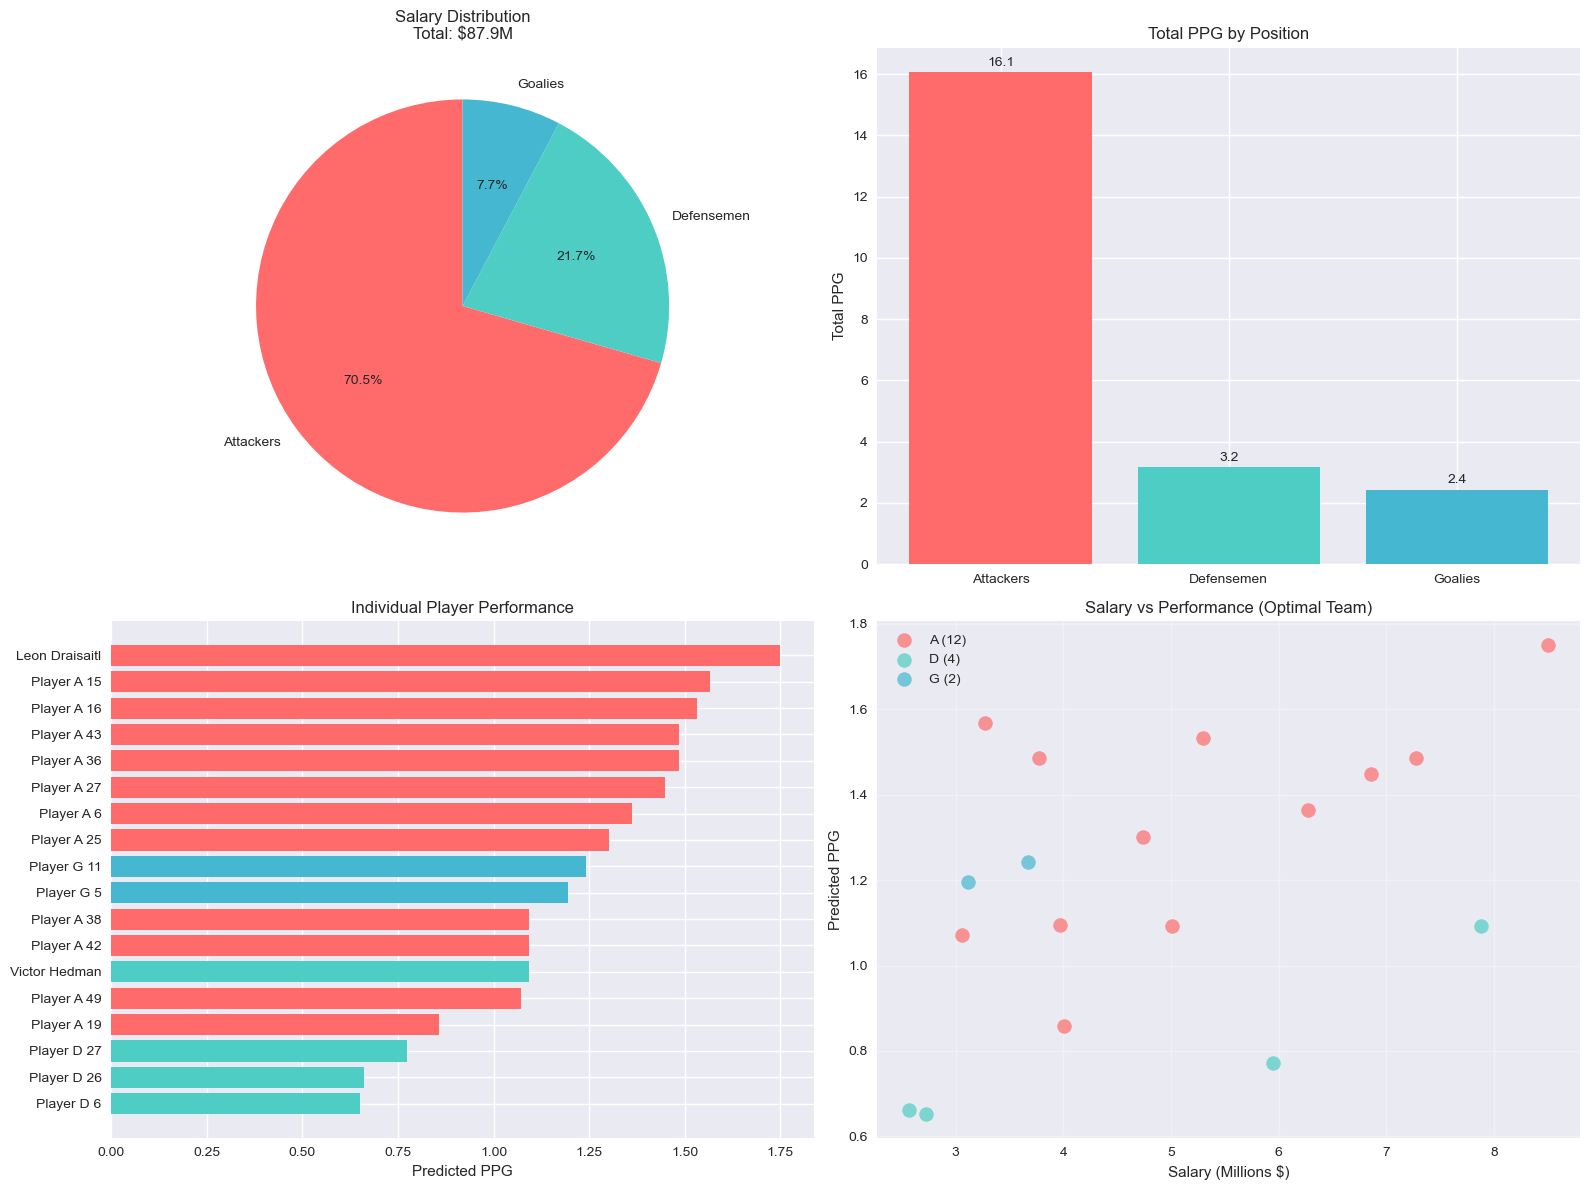

📈 Visualizations complete!


In [8]:
if solution and solution['status'] == 'Optimal':
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Salary distribution by position
    position_salaries = optimal_df.groupby('Role')['Salary_M'].sum()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    wedges, texts, autotexts = axes[0,0].pie(position_salaries.values, 
                                           labels=['Attackers', 'Defensemen', 'Goalies'],
                                           autopct='%1.1f%%', 
                                           colors=colors,
                                           startangle=90)
    axes[0,0].set_title(f'Salary Distribution\nTotal: ${solution["total_salary"]/1000000:.1f}M')
    
    # 2. PPG by position
    position_ppg = optimal_df.groupby('Role')['Predicted_PPG'].sum()
    axes[0,1].bar(['Attackers', 'Defensemen', 'Goalies'], position_ppg.values, color=colors)
    axes[0,1].set_title('Total PPG by Position')
    axes[0,1].set_ylabel('Total PPG')
    
    # Add value labels on bars
    for i, v in enumerate(position_ppg.values):
        axes[0,1].text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom')
    
    # 3. Individual player performance
    optimal_df_sorted = optimal_df.sort_values('Predicted_PPG', ascending=True)
    y_pos = range(len(optimal_df_sorted))
    
    # Color by position
    role_colors = {'A': '#FF6B6B', 'D': '#4ECDC4', 'G': '#45B7D1'}
    bar_colors = [role_colors[role] for role in optimal_df_sorted['Role']]
    
    bars = axes[1,0].barh(y_pos, optimal_df_sorted['Predicted_PPG'], color=bar_colors)
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels([name[:15] for name in optimal_df_sorted['Name']])
    axes[1,0].set_xlabel('Predicted PPG')
    axes[1,0].set_title('Individual Player Performance')
    
    # 4. Salary vs PPG scatter
    for role in ['A', 'D', 'G']:
        role_data = optimal_df[optimal_df['Role'] == role]
        axes[1,1].scatter(role_data['Salary_M'], role_data['Predicted_PPG'], 
                         color=role_colors[role], s=100, alpha=0.7, 
                         label=f'{role} ({len(role_data)})')
    
    axes[1,1].set_xlabel('Salary (Millions $)')
    axes[1,1].set_ylabel('Predicted PPG')
    axes[1,1].set_title('Salary vs Performance (Optimal Team)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Visualizations complete!")
else:
    print("❌ No solution to visualize")

## 6. Alternative Optimization Scenarios

🧪 Testing Alternative Scenarios:

📋 Scenario: Standard Rules
   Budget: $88,000,000, Positions: 12A/6D/2G
🔧 Setting up optimization problem...
Players to consider: 105
Constraints: $88,000,000 budget, 12A/6D/2G
🚀 Solving optimization problem...
📊 Solution Status: Optimal

🎉 OPTIMAL SOLUTION FOUND!
Total Players: 18
Total PPG: 21.67
Total Salary: $87,931,013 (99.9% of cap)
Position Distribution: 12A, 4D, 2G

📋 Scenario: Higher Budget
   Budget: $95,000,000, Positions: 12A/6D/2G
🔧 Setting up optimization problem...
Players to consider: 105
Constraints: $95,000,000 budget, 12A/6D/2G
🚀 Solving optimization problem...
📊 Solution Status: Optimal

🎉 OPTIMAL SOLUTION FOUND!
Total Players: 19
Total PPG: 22.67
Total Salary: $94,798,029 (99.8% of cap)
Position Distribution: 12A, 5D, 2G

📋 Scenario: More Attackers
   Budget: $88,000,000, Positions: 14A/4D/2G
🔧 Setting up optimization problem...
Players to consider: 105
Constraints: $88,000,000 budget, 14A/4D/2G
🚀 Solving optimization problem...
📊 

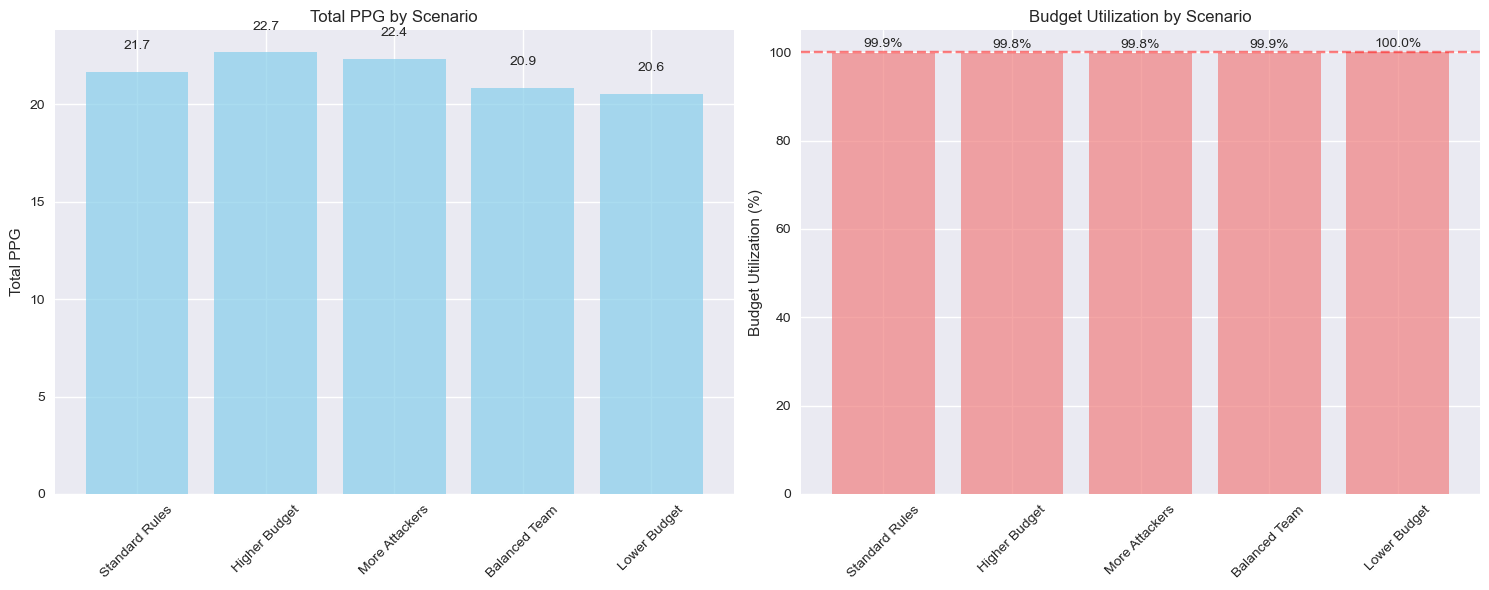

In [9]:
# Test different constraint scenarios
scenarios = [
    {'name': 'Standard Rules', 'budget': 88000000, 'A': 12, 'D': 6, 'G': 2},
    {'name': 'Higher Budget', 'budget': 95000000, 'A': 12, 'D': 6, 'G': 2},
    {'name': 'More Attackers', 'budget': 88000000, 'A': 14, 'D': 4, 'G': 2},
    {'name': 'Balanced Team', 'budget': 88000000, 'A': 10, 'D': 8, 'G': 2},
    {'name': 'Lower Budget', 'budget': 80000000, 'A': 12, 'D': 6, 'G': 2}
]

scenario_results = []

print("🧪 Testing Alternative Scenarios:")
print("=" * 60)

for scenario in scenarios:
    print(f"\n📋 Scenario: {scenario['name']}")
    print(f"   Budget: ${scenario['budget']:,}, Positions: {scenario['A']}A/{scenario['D']}D/{scenario['G']}G")
    
    result = solve_optimal_team(players, 
                               salary_cap=scenario['budget'],
                               max_attackers=scenario['A'],
                               max_defensemen=scenario['D'],
                               max_goalies=scenario['G'])
    
    if result and result['status'] == 'Optimal':
        scenario_results.append({
            'Scenario': scenario['name'],
            'Budget': scenario['budget']/1000000,
            'Total_PPG': result['total_ppg'],
            'Total_Salary': result['total_salary']/1000000,
            'Utilization_%': result['salary_utilization']*100,
            'Players': len(result['players']),
            'Attackers': result['position_counts']['A'],
            'Defensemen': result['position_counts']['D'],
            'Goalies': result['position_counts']['G']
        })
    else:
        print(f"   ❌ No feasible solution")

# Display scenario comparison
if scenario_results:
    scenario_df = pd.DataFrame(scenario_results)
    print("\n📊 SCENARIO COMPARISON:")
    print(scenario_df.round(2))
    
    # Plot scenario comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # PPG comparison
    bars1 = ax1.bar(scenario_df['Scenario'], scenario_df['Total_PPG'], 
                    color='skyblue', alpha=0.7)
    ax1.set_title('Total PPG by Scenario')
    ax1.set_ylabel('Total PPG')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars1, scenario_df['Total_PPG']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}', ha='center', va='bottom')
    
    # Budget utilization
    bars2 = ax2.bar(scenario_df['Scenario'], scenario_df['Utilization_%'], 
                    color='lightcoral', alpha=0.7)
    ax2.set_title('Budget Utilization by Scenario')
    ax2.set_ylabel('Budget Utilization (%)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Full Budget')
    
    # Add value labels
    for bar, value in zip(bars2, scenario_df['Utilization_%']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No scenario results to display")

## 7. Export Results

In [10]:
if solution and solution['status'] == 'Optimal':
    # Export optimal team to CSV
    export_filename = f"optimal_nhl_team_{CURRENT_SEASON}.csv"
    optimal_df.to_csv(export_filename, index=False)
    print(f"💾 Optimal team exported to: {export_filename}")
    
    # Export scenario comparison
    if scenario_results:
        scenario_filename = f"scenario_comparison_{CURRENT_SEASON}.csv"
        scenario_df.to_csv(scenario_filename, index=False)
        print(f"💾 Scenario comparison exported to: {scenario_filename}")
    
    # Create summary report
    summary_filename = f"optimization_summary_{CURRENT_SEASON}.txt"
    with open(summary_filename, 'w') as f:
        f.write(f"NHL POOL OPTIMIZATION SUMMARY\n")
        f.write(f"Season: {CURRENT_SEASON}\n")
        f.write(f"Generated: {pd.Timestamp.now()}\n")
        f.write(f"\n" + "="*50 + "\n")
        
        f.write(f"OPTIMAL TEAM RESULTS:\n")
        f.write(f"Total Players: {len(solution['players'])}\n")
        f.write(f"Total PPG: {solution['total_ppg']:.2f}\n")
        f.write(f"Total Salary: ${solution['total_salary']:,}\n")
        f.write(f"Budget Utilization: {solution['salary_utilization']*100:.1f}%\n")
        f.write(f"Position Distribution: {solution['position_counts']}\n")
        
        f.write(f"\nCONSTRAINTS USED:\n")
        f.write(f"Salary Cap: ${SALARY_CAP:,}\n")
        f.write(f"Max Attackers: {MAX_ATTACKERS}\n")
        f.write(f"Max Defensemen: {MAX_DEFENSEMEN}\n")
        f.write(f"Max Goalies: {MAX_GOALIES}\n")
        
        f.write(f"\nPLAYER POOL:\n")
        f.write(f"Total Players Considered: {len(players)}\n")
        
        role_counts = {}
        for player in players:
            role_counts[player.role] = role_counts.get(player.role, 0) + 1
        
        for role, count in role_counts.items():
            f.write(f"{role}: {count} players\n")
    
    print(f"💾 Summary report exported to: {summary_filename}")
    
    print(f"\n✅ All results exported successfully!")
    print(f"Files created:")
    print(f"  - {export_filename}")
    if scenario_results:
        print(f"  - {scenario_filename}")
    print(f"  - {summary_filename}")
else:
    print(f"❌ No results to export")

💾 Optimal team exported to: optimal_nhl_team_20242025.csv
💾 Scenario comparison exported to: scenario_comparison_20242025.csv
💾 Summary report exported to: optimization_summary_20242025.txt

✅ All results exported successfully!
Files created:
  - optimal_nhl_team_20242025.csv
  - scenario_comparison_20242025.csv
  - optimization_summary_20242025.txt


## 8. Summary and Next Steps

In [11]:
print("🎯 NHL POOL OPTIMIZATION COMPLETE!")
print("=" * 50)

if solution and solution['status'] == 'Optimal':
    print(f"\n🏆 FINAL RESULTS:")
    print(f"Optimal Team Found: ✅")
    print(f"Total Players: {len(solution['players'])}")
    print(f"Predicted Team PPG: {solution['total_ppg']:.2f}")
    print(f"Total Salary: ${solution['total_salary']:,}")
    print(f"Budget Efficiency: {solution['salary_utilization']*100:.1f}%")
    print(f"Team Composition: {solution['position_counts']['A']} Attackers, {solution['position_counts']['D']} Defensemen, {solution['position_counts']['G']} Goalies")
    
    print(f"\n📊 KEY INSIGHTS:")
    avg_salary = solution['total_salary'] / len(solution['players'])
    avg_ppg = solution['total_ppg'] / len(solution['players'])
    print(f"• Average player salary: ${avg_salary:,.0f}")
    print(f"• Average player PPG: {avg_ppg:.2f}")
    print(f"• Total value generated: {solution['total_ppg']:.1f} PPG for ${solution['total_salary']/1000000:.1f}M")
    
    # Best value players
    best_values = optimal_df.nlargest(3, 'Value_Ratio')
    print(f"• Best value players:")
    for _, player in best_values.iterrows():
        print(f"  - {player['Name']}: {player['Value_Ratio']:.2f} PPG/$M")
    
    print(f"\n🚀 NEXT STEPS:")
    print(f"1. Review the optimal team composition")
    print(f"2. Consider player availability and injury status")
    print(f"3. Monitor salary cap changes and player trades")
    print(f"4. Update predictions with latest performance data")
    print(f"5. Run scenario analysis for different constraints")
    
    print(f"\n💡 RECOMMENDATIONS:")
    if solution['salary_utilization'] < 0.95:
        unused_budget = (1 - solution['salary_utilization']) * SALARY_CAP
        print(f"• Consider using remaining ${unused_budget:,.0f} budget for upgrades")
    
    if len(solution['players']) < TOTAL_PLAYERS:
        remaining_spots = TOTAL_PLAYERS - len(solution['players'])
        print(f"• {remaining_spots} roster spots available for additional players")
    
    print(f"• Focus on high-value attackers and reliable defensemen")
    print(f"• Monitor goalie performance as it's often volatile")
    print(f"• Consider injury risk vs. performance potential")
    
else:
    print(f"❌ Optimization failed - check constraints and player data")
    print(f"\n🔧 TROUBLESHOOTING:")
    print(f"• Verify salary cap and position limits are realistic")
    print(f"• Check that player salaries are accurate")
    print(f"• Ensure sufficient players in each position category")
    print(f"• Review data quality and completeness")

print(f"\n📚 For more details, refer to the generated CSV files and summary report.")
print(f"🎉 Optimization notebook complete!")

🎯 NHL POOL OPTIMIZATION COMPLETE!

🏆 FINAL RESULTS:
Optimal Team Found: ✅
Total Players: 18
Predicted Team PPG: 21.67
Total Salary: $87,931,013
Budget Efficiency: 99.9%
Team Composition: 12 Attackers, 4 Defensemen, 2 Goalies

📊 KEY INSIGHTS:
• Average player salary: $4,885,056
• Average player PPG: 1.20
• Total value generated: 21.7 PPG for $87.9M
• Best value players:
  - Player A 15: 0.48 PPG/$M
  - Player A 36: 0.39 PPG/$M
  - Player G 5: 0.38 PPG/$M

🚀 NEXT STEPS:
1. Review the optimal team composition
2. Consider player availability and injury status
3. Monitor salary cap changes and player trades
4. Update predictions with latest performance data
5. Run scenario analysis for different constraints

💡 RECOMMENDATIONS:
• 2 roster spots available for additional players
• Focus on high-value attackers and reliable defensemen
• Monitor goalie performance as it's often volatile
• Consider injury risk vs. performance potential

📚 For more details, refer to the generated CSV files and sum